# Big project activity

## Optimal charging station location

### 1.Introduction

Consider a long linear cycle path as Vento, or the Danube cycle path. The cycle path usually runs along the banks of a river with scarce tourist interest. However, from the main course of the cycle path, it is possible to reach places of tourist interest in making small detours.  

The rapid growth of e-bike ridership is proposing the problem of deploying a suitable charging infrastructure. The charging stations should be placed in strategic positions so as to guarantee a coverage of the whole cycle path. However, since the charging operations require a non-negligible time, the charging station should be positioned in places where alternative activities could be carried out, as restaurants, museums, swimming pool, or other amenities. Moreover, the presence of a charging station could also induce e-cyclists to discover new places and generate positive externalities.



### 2.Decision problem
We can represent the cycle path as a graph where the set of nodes $H = \{1,\ldots, n\}$ corresponds to the tourist sites that may host a charging station.
In addition, we are given the distances between touristic sites ($d_{ij},$ with $ i,j =1,\ldots,n$). Let $c_i$ be the cost of installing a charging station in site $i, i=1\ldots, n$.


The problem is, given a budget $b$, determine the subset of sites $S\subseteq H$ where to install the charging stations so that the total cost is not higher than $b$ and the maximum distance between consecutive charging stations is minimized.
Consider that the cyclist has to visit all the touristic destinations in a consecutive way.



### 3.Problem characteristics
There are 2 csv files that contain the information of the cycle way, they are essential to build the equivalent graph:


*    in the "nodes.csv" file, there are all the destinations that the cyclist can reach, with their spatial coordinates and the value of installation costs related to that destination. Consider that the "tourist-dest-id" is not the graph node number, but it is a unique id to identify the destination.
*   in the "OD.csv" you can find all the arcs between two different nodes, keep attention that the condition of visiting consecutive touristic destination must be respected.

The set of nodes $N$ is defined by $\{0,1,\ldots,n, n+1\}$.  The Arcs $A$ correspond to the portion of cycle path between two consecutive charging stations. We assume that potentially e-riders will visit all sites along the way, making the suitable deviations and going back to the main path at the initial point of the detour.
The cost associated with each arc $(i,j)$ is given by $c_j$, thus the cost of installing a charging station in $j$. These costs are defined for all arcs in $A$, while they are set to 0 for all the arcs that arrive in the last node.
The path starts in node $s = 0$ and ends in node $t = n+1$, these two nodes are connected to the nearest touristic site with an arc of null length.

### 4.Example of a linear path with deviation
![picture](https://drive.google.com/uc?export=view&id=1w16bHtbu0FGGL-UntxeqxD7244D3eHbJ)

### 5.Requirements
The requirements of the problem are:


*   the maximum running time of the algorithm must be 5 minutes, so set the proper timer
*   create the equivalent graph and display it on a xy-plot
*   find the solution for the basic scenario, with a mip model, displaying the solution with a xy-plot, the budget constraint is $b = 10000\ € $.
*   Find the optimal solution for 5 different values of budget in the range $[10000, 100000]$. Select the values of the budget so as to have different charger locations.

  You have to motivate your choice and the solution you get. They can also be not common solution if they are well motivated. To support your decision and explanations, you can print plots or tables. You can also compare different scenarios.


   
If you have some doubts related to the parametric analysis, prof. Cubillos uploaded a notebook with the solution on WeBeeP and you can have a look there.

### Insert student name and student ID

student1:

ID1:

student2:

ID2:

student3

ID3:



In [2]:
#install libraries
!pip install mip
!pip install --upgrade cffi==1.15.0

In [3]:
#import libraries
import importlib
import cffi

importlib.reload(cffi)
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import time
import random

In [4]:
# set the budget
budget: int = 10_000
# budget = random.randint(10000, 100000)
print(f"Budget: {budget:,.2f} €")

Budget: 10,000.00 €


In [5]:
# Load nodes data from CSV
nodes_data: pd.DataFrame = pd.read_csv('nodes.csv')

# Display information about candidate touristic sites and nodes
num_nodes: int = len(nodes_data) + 2
print(f"Number of candidate touristic sites: {len(nodes_data)}")
print(f"Number of Nodes (including source and sink): {num_nodes}")

# Load OD data from CSV and map node IDs
od_data: pd.DataFrame = pd.read_csv('OD.csv')
node_id_mapping: dict[int, int] = {node_id: i for i, node_id in enumerate(nodes_data['tourist_dest_id'])}
od_data[['origin_id', 'destination_id']] = od_data[['origin_id', 'destination_id']].apply(
    lambda x: x.map(node_id_mapping))

# Map node IDs in nodes_data
nodes_data['tourist_dest_id'] = nodes_data['tourist_dest_id'].map(node_id_mapping)

# Display the number of arcs and the node ID mapping
print(f"Number of arcs: {len(od_data)}")
print(f"Node ID Mapping: {node_id_mapping}")


Number of candidate touristic sites: 44
Number of Nodes (including source and sink): 46
Number of arcs: 1936
Node ID Mapping: {0: 0, 17: 1, 18: 2, 20: 3, 21: 4, 23: 5, 24: 6, 25: 7, 29: 8, 30: 9, 31: 10, 32: 11, 33: 12, 35: 13, 36: 14, 38: 15, 39: 16, 40: 17, 41: 18, 48: 19, 52: 20, 53: 21, 54: 22, 57: 23, 58: 24, 60: 25, 61: 26, 62: 27, 63: 28, 64: 29, 66: 30, 67: 31, 68: 32, 69: 33, 77: 34, 82: 35, 83: 36, 84: 37, 85: 38, 86: 39, 87: 40, 88: 41, 89: 42, 90: 43}


In [6]:
import folium
from branca.element import Figure


def create_folium_map(candidate_sites_coordinates: pd.DataFrame, center: list[float]) -> folium.Map:
    """
    Creates a Folium map with CircleMarkers for candidate sites.

    Parameters:
    - candidate_sites_coordinates (pd.DataFrame): DataFrame containing candidate sites data with 'y (latitude)', 'x (longitude)',
      'Comune', 'Piazza', and 'tourist_dest_id'.
    - center (List[float]): List representing the center location of the map [latitude, longitude].

    Returns:
    - folium.Map: Folium map with CircleMarkers for candidate sites.
    """
    # Initialize the map
    map = folium.Map(location=center, zoom_start=10)

    # Add CircleMarkers for each row in candidate_sites_coordinates
    for _, row in candidate_sites_coordinates.iterrows():
        popup_text = f"{row['Comune']} - {row['Piazza']}" if pd.notna(row['Piazza']) else f"{row['Comune']}"

        folium.CircleMarker(
            location=[row['y (latitude)'], row['x (longitude)']],
            radius=5,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            popup=popup_text,
            tooltip=str(row['tourist_dest_id'])
        ).add_to(map)

    return map


# Center location
map_center: list[float] = [44.92803444, 10.52108953]

# Create Folium map with the specified center
nodes_map: folium.Map = create_folium_map(candidate_sites_coordinates=nodes_data, center=map_center)

# Create a Figure and add the Folium map to it
fig: Figure = Figure(width=1000, height=700)
fig.add_child(nodes_map)

# Display the Figure
fig

In [7]:
def find_first_node(nodes_data: pd.DataFrame) -> int:
    """
    Finds the first node based on the lowest value of longitude.

    Parameters:
    - nodes_data (pd.DataFrame): DataFrame containing node data with 'tourist_dest_id', 'x (longitude)', 'y (latitude)', etc.

    Returns:
    - int: The tourist destination ID of the node with the lowest longitude.
    """
    min_longitude_row = nodes_data.loc[nodes_data['x (longitude)'].idxmin()]
    return min_longitude_row['tourist_dest_id']


def find_last_node(nodes_data: pd.DataFrame) -> int:
    """
    Finds the last node based on the highest value of longitude.

    Parameters:
    - nodes_data (pd.DataFrame): DataFrame containing node data with 'tourist_dest_id', 'x (longitude)', 'y (latitude)', etc.

    Returns:
    - int: The tourist destination ID of the node with the highest longitude.
    """
    max_longitude_row = nodes_data.loc[nodes_data['x (longitude)'].idxmax()]
    return max_longitude_row['tourist_dest_id']


In [9]:
#set the timer
# Starting time
start_time = time.time()
#TO DO

## Shortest path -> Graph
This algorithm is used to find the shortest path between two nodes (head, tail). In this case:
- Head: 0
- Tail: 20 (52 in the original OD file) -> selected because is the furthest from 0 if we look at the path (this selection of the node could be automatized)

In [11]:
import mip
import math

n = len(nodes_data)
distance_matrix = [[0 for j in range(n)] for i in range(n)]

for _, row in od_data.iterrows():
    i, j = int(row['origin_id']), int(row['destination_id'])
    if math.isnan(row['distance [m]']):
        distance_matrix[i][j] = 0
    else:
        distance_matrix[i][j] = row['distance [m]']

# Create model
m = mip.Model()

# define the variables
x = [[m.add_var(var_type=mip.BINARY) for j in range(n)] for i in range(n)]
print(f"Number y (arc ij is selected or not) of variables: {len(x)}")

#  define the constraints
first_node = find_first_node(nodes_data)
last_node = find_last_node(nodes_data)

for i in range(n):
    m += x[i][i] == 0
    if i == last_node:
        m += mip.xsum(x[i][j] for j in range(n) if i != j) == 0  # set the sink node to 20 -> no outgoing arcs
    else:
        m += mip.xsum(x[i][j] for j in range(n) if i != j) == 1

    if i == first_node:
        m += mip.xsum(x[j][i] for j in range(n) if i != j) == 0  # set the source node to 0 -> no incoming arcs
    else:
        m += mip.xsum(x[j][i] for j in range(n) if i != j) == 1

    # Sub-tour elimination
u = [m.add_var() for i in range(n)]
for i in range(1, n):
    for j in range(1, n):
        if i != j:
            m += u[i] - u[j] + (n - 1) * x[i][j] <= n - 2

# optimize objective function
m.objective = mip.minimize(mip.xsum(distance_matrix[i][j] * x[i][j] for i in range(n) for j in range(n)))

m.optimize()

path = []
for i in range(n):
    for j in range(n):
        if x[i][j].x > 0.5:  # If the path is chosen in the solution
            path.append((i, j))

# Display the solution path
print("Optimal path:", path)

current_node = 0

# Initialize the ordered path list with the start node
ordered_path = [current_node]

# Loop until we reach the end node (20 in this case)
while current_node != 20:
    for j in range(n):
        if x[current_node][j].x >= 0.99:  # If the path goes from current_node to j
            ordered_path.append(j)  # Add j to the path
            current_node = j  # Update the current node to j
            break

# Print the ordered path
print("Ordered path from 0 to 20:", ordered_path)

total_distance = 0

# Iterate over the path to sum the distances
for i in range(len(ordered_path) - 1):
    total_distance += distance_matrix[ordered_path[i]][ordered_path[i + 1]]

print("Total distance from start to finish:", total_distance)

Number y (arc ij is selected or not) of variables: 44
Optimal path: [(0, 43), (1, 2), (2, 3), (3, 4), (4, 5), (5, 34), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 33), (19, 24), (21, 20), (22, 21), (23, 22), (24, 23), (25, 19), (26, 27), (27, 25), (28, 26), (29, 28), (30, 29), (31, 30), (32, 31), (33, 32), (34, 6), (35, 36), (36, 37), (37, 1), (38, 39), (39, 35), (40, 38), (41, 40), (42, 41), (43, 42)]
Ordered path from 0 to 20: [0, 43, 42, 41, 40, 38, 39, 35, 36, 37, 1, 2, 3, 4, 5, 34, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 33, 32, 31, 30, 29, 28, 26, 27, 25, 19, 24, 23, 22, 21, 20]
Total distance from start to finish: 238507.22819670002


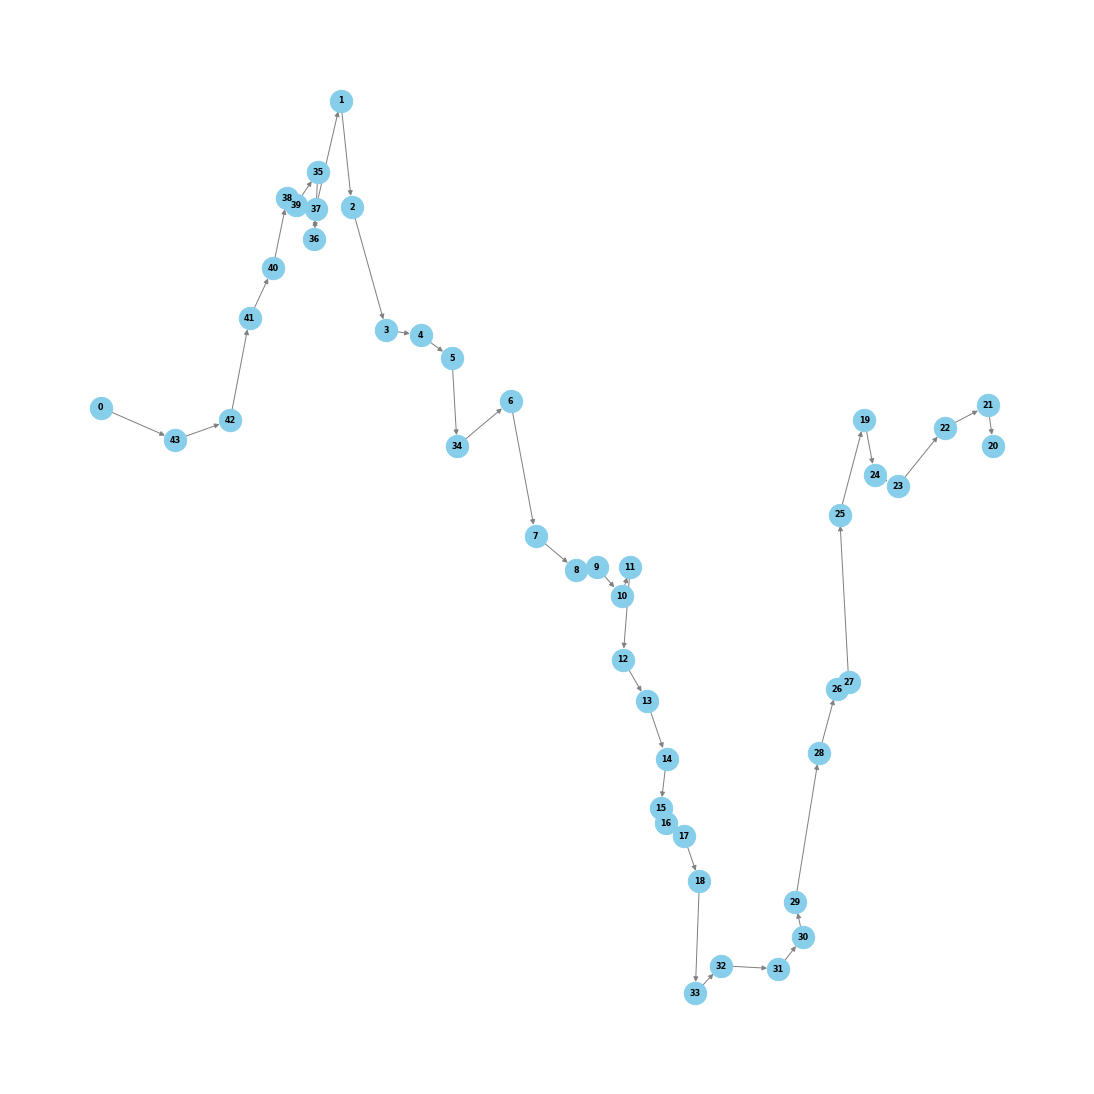

In [25]:
G = nx.DiGraph()

# Add nodes
for i, row in nodes_data.iterrows():
    G.add_node(row["tourist_dest_id"], pos=(row["x (longitude)"], row["y (latitude)"]),
               label=row["Comune"] + " - " + str(row["Piazza"]))

# Add edges for the optimal path
for i in range(len(path)):
    origin, destination = path[i]
    G.add_edge(origin, destination, distance=distance_matrix[origin][destination])

plt.figure(figsize=(15, 15))

# Draw the graph
pos = nx.get_node_attributes(G, "pos")
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, font_color="black", font_weight="bold",
        node_color="skyblue", edge_color="gray", arrowsize=10)

plt.show()

Accumulated distance: 16011.18979 meters
Accumulated distance: 29832.45227 meters
Accumulated distance: 34130.609288 meters
Accumulated distance: 39610.193432 meters
Accumulated distance: 43246.561147 meters
Accumulated distance: 44815.590338 meters
Accumulated distance: 49574.269353 meters
Accumulated distance: 51817.123448000006 meters
Accumulated distance: 13821.26248 meters
Accumulated distance: 18119.419498 meters
Accumulated distance: 23599.003642 meters
Accumulated distance: 27235.371357 meters
Accumulated distance: 28804.400548 meters
Accumulated distance: 33563.079563 meters
Accumulated distance: 35805.933658 meters
Accumulated distance: 36795.4581417 meters
Accumulated distance: 42846.9603267 meters
Accumulated distance: 49871.7452367 meters
Accumulated distance: 62060.2597767 meters
Accumulated distance: 4298.157018 meters
Accumulated distance: 9777.741162 meters
Accumulated distance: 13414.108877 meters
Accumulated distance: 14983.138068 meters
Accumulated distance: 19741.8

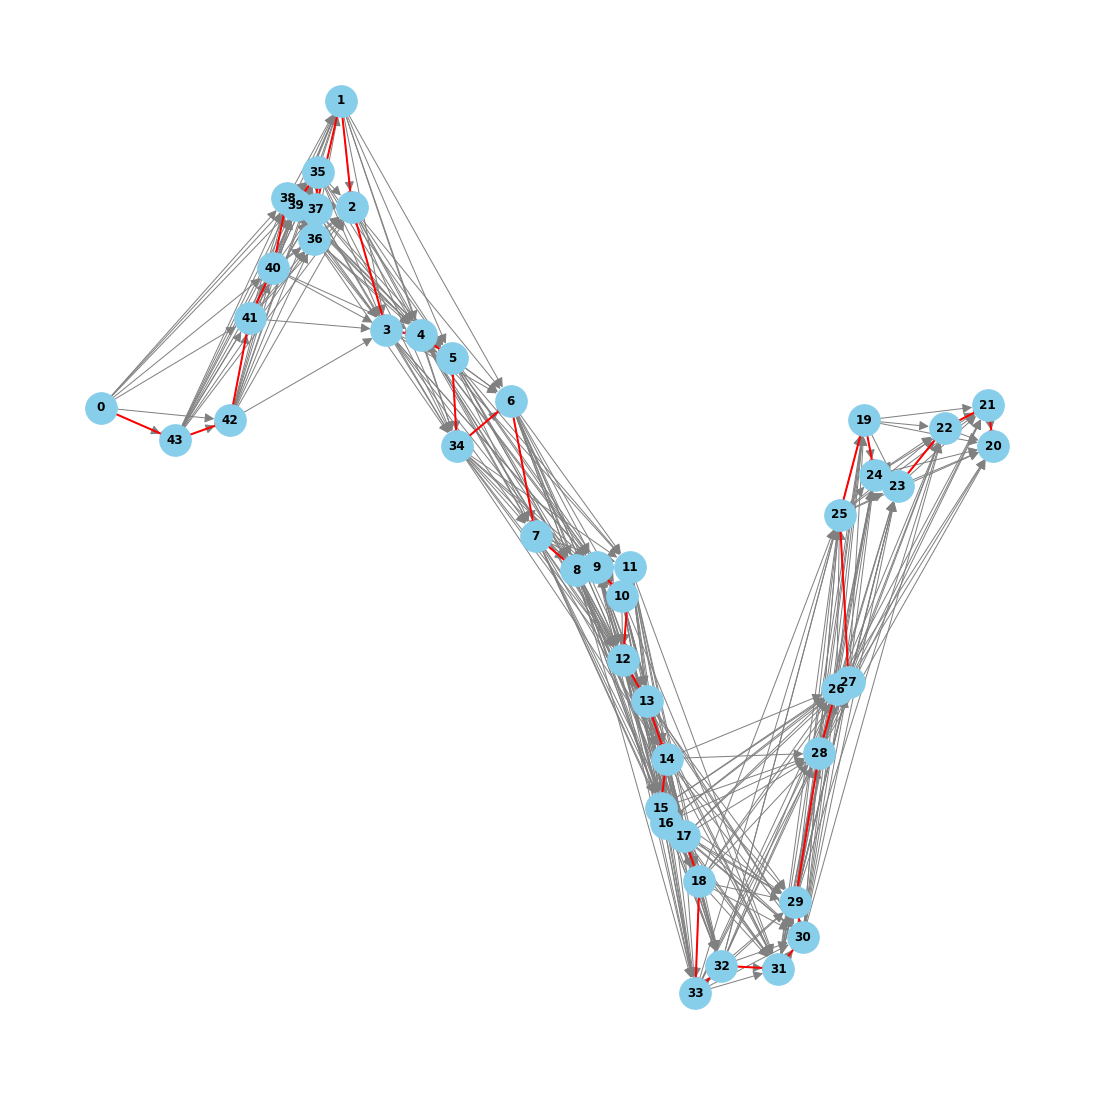

In [34]:
max_distance = 50000  # 50,000 meters


for start_node in ordered_path:
    accumulated_distance = 0
    support_node = start_node
    for next_node in ordered_path[ordered_path.index(start_node) + 1:]:
        # Calculate the distance to the next node
        distance_to_next = distance_matrix[support_node][next_node]
        accumulated_distance += distance_to_next
        print(f"Accumulated distance: {accumulated_distance} meters")

        # If accumulated distance is within the limit, add the edge
        if accumulated_distance <= max_distance:
            if not G.has_edge(support_node, next_node):
                G.add_edge(support_node, next_node, distance=accumulated_distance)
        else:
            # Stop adding edges if the distance limit (50km) is exceeded
            break
        support_node = next_node

# Create a list of edges for the original path
original_path_edges = [(ordered_path[i], ordered_path[i + 1]) for i in range(len(ordered_path) - 1)]

# Visualization
plt.figure(figsize=(15, 15))
# Draw the graph with all connections
nx.draw(G, pos, with_labels=True, node_size=1000, font_size=12, font_color="black", font_weight="bold",
        node_color="skyblue", edge_color="gray", arrowsize=20)

# Highlight the original path in red
nx.draw_networkx_edges(G, pos, edgelist=original_path_edges, edge_color='red', width=2)

plt.show()

If you want to reset the graph to its original state, run the cell on top of this one again.

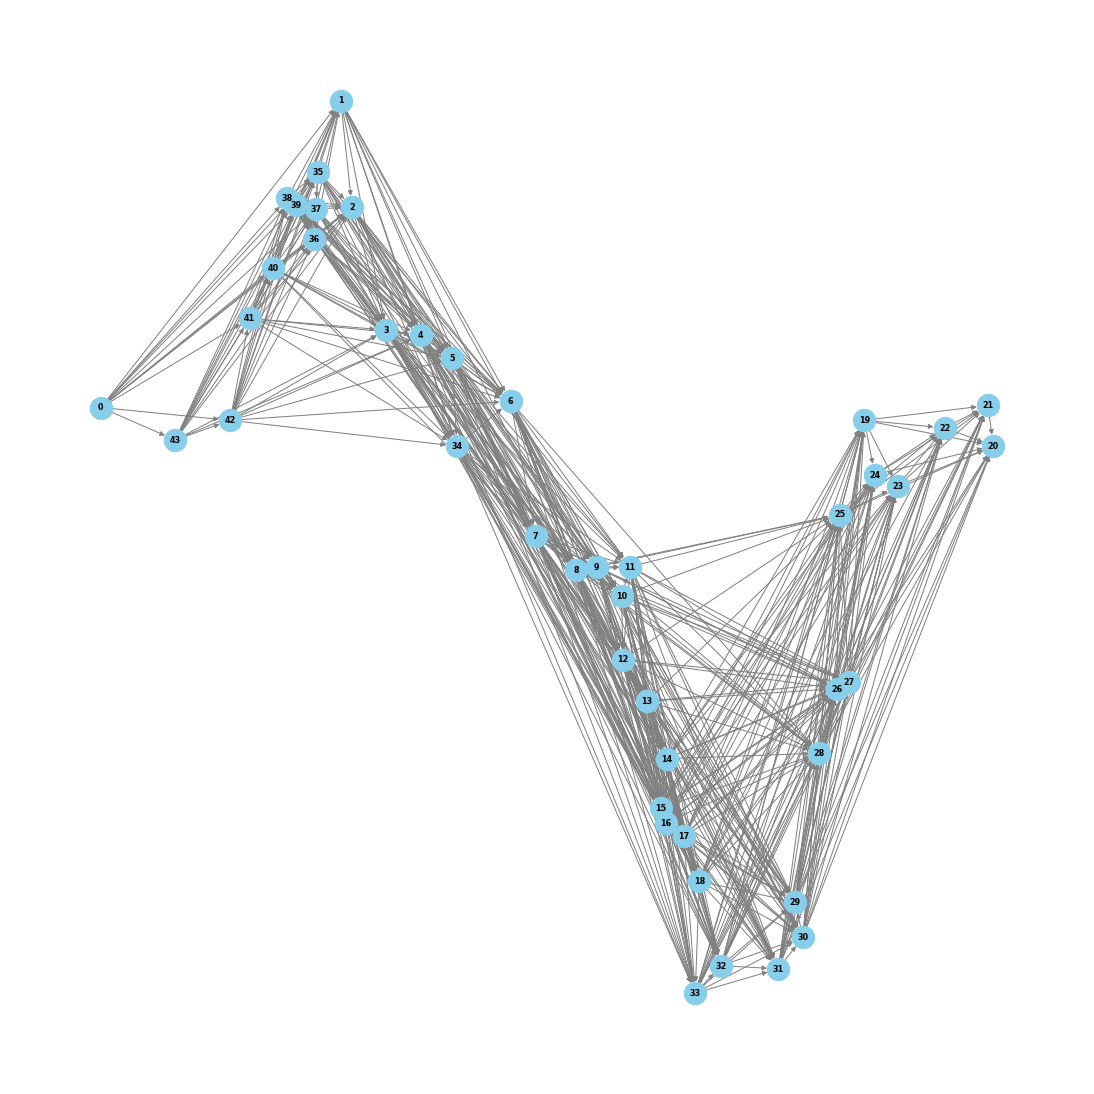

In [13]:
max_distance = 5_0000
count = 0

for i, node in enumerate(ordered_path):
    for j in range(n):
        # Check if the node is not the next node in the path and is within the distance limit
        if j != node and (i == len(ordered_path) - 1 or j != ordered_path[i + 1]) and distance_matrix[node][
            j] <= max_distance:
            # Add an edge only if there isn't already an edge in either direction
            if not G.has_edge(node, j) and not G.has_edge(j, node):
                count = count + 1
                G.add_edge(node, j, distance=distance_matrix[node][j])

# Update the graph
pos = nx.get_node_attributes(G, "pos")
plt.figure(figsize=(15, 15))
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, font_color="black", font_weight="bold",
        node_color="skyblue", edge_color="gray", arrowsize=10)

plt.show()

In [ ]:
import mip

# Create model
m = mip.Model()

# define the variables

# TO DO


#  define the constraints
# Budget Constraint

# Flow Conservation Constraints


# TO DO


# optimize objective function
# TO DO


m.optimize()

In [ ]:
print(m.objective_value)

In [ ]:
#plot the graph

#TO DO

In [ ]:
# parametric analysis


#TO DO



